In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import subprocess
from typing import List
from osgeo import gdal
from spatial_interpolation import ordinary_kriging, create_interpolation_data,calculate_distances,idw_2d

### Import data and pre-process

In [3]:
#path to source directory
src=r"W:/VUB/main_research/data/molenbeek_bgk/obs_data"

In [4]:
gw_data=pd.read_excel(os.path.join(src,"peilbuizen_wetspass.xlsx"), sheet_name="DATA")
elevation_data=pd.read_excel(os.path.join(src,"GWTable.xlsx"), sheet_name="GWs_Elev_data")
sensor_coords=pd.read_csv(os.path.join(src,"peil_locations_c.csv"))


gw_data_int=gw_data.drop('COMMENTAAR', axis=1)

# convert period column to datetime
gw_data_int['date']=pd.to_datetime(gw_data_int['periode (halve maand)'], format='%Y_%m_%d')

#sort the data by date
gw_df_processed=gw_data_int.sort_values('date').set_index('date').drop('periode (halve maand)',axis=1)

In [5]:
"""the data is measured twice a month on the first and second half. so we assume the first monthly 
measurement is taken on the first day and the 2nd measurement on the 15th day"""

mask = gw_df_processed.index.day == 2

if mask.any():
    gw_df_processed.index = gw_df_processed.index.where(~mask, gw_df_processed.index + pd.DateOffset(days=13))

gw_monthly_depth=gw_df_processed.resample('M').mean()*0.01*-1 # resample to monthly and convert from cm to meters. "*-1" converts measurements to depth below surface
gw_monthly_depth.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,C3,C4,D1,D2,D3,D4
date,,,,,,,,,,,,,,,,
2003-09-30,3.400,0.900,1.110,2.36,2.920,2.090,1.090,2.480,NaN,0.780,1.200,2.870,NaN,1.260,1.09,1.340
2003-10-31,3.345,0.615,0.800,2.16,2.905,2.065,0.925,2.385,NaN,0.695,1.085,2.790,NaN,1.180,0.99,1.195
2003-11-30,3.240,0.585,0.745,2.00,2.895,2.065,0.845,2.290,NaN,0.495,0.840,2.875,NaN,1.050,0.81,0.920
2003-12-31,2.985,0.115,0.215,1.43,2.620,1.775,0.255,1.510,NaN,0.200,0.350,2.070,NaN,0.810,0.57,0.320
2004-01-31,1.925,0.005,0.115,0.94,1.755,1.040,0.060,0.855,NaN,0.090,0.205,1.150,2.865,0.555,0.43,0.195


### Spatial interpolation with Krigging

In [5]:
min_x, max_x, min_y, max_y = 159600, 163350, 205500, 207200
z,ss,data=ordinary_kriging(gw_monthly_depth,sensor_coords,min_x,max_x, min_y,max_y,10,'exponential')

### Inverse Distance Weighting interpolation

In [5]:
#generate a grid of coordinates to be used for interpolation
#Gridpoints correspond to the bounds of the DEM/study area to interpolate the groundwater data (BE Lambert Coordinate system). 5 is the resolution of the interpolation space
gridx = np.arange(159600, 163350, 10,dtype=np.float64) 
gridy = np.arange(207200,205500,-10, dtype=np.float64)

target_grid=np.meshgrid(gridx, gridy)

#### Elevation data

In [18]:
elevation_grid=gdal.Open(r"W:\VUB\main_research\data\molenbeek_bgk\dem\beggelbeek_10m.tif")
elevation_array=elevation_grid.ReadAsArray()

#create an data array of elevation data
elevation_xr=xr.DataArray(elevation_array, coords=[gridy, gridx], dims=["lat", "lon"])
# Convert the DataArray to a Dataset
elevation_dataset = xr.Dataset({"elevation": elevation_xr})

#### Interpolate and create a Dataset of groundwater table and groundwater levels

In [6]:
gw_data_stack_list=create_interpolation_data(gw_monthly_depth,sensor_coords)

In [12]:
gw_data_stack_list[0]

array([[1.6054857e+05, 2.0685255e+05, 3.4000000e+00],
       [1.6054635e+05, 2.0656068e+05, 9.0000000e-01],
       [1.6058553e+05, 2.0639475e+05, 1.1100000e+00],
       [1.6066036e+05, 2.0617735e+05, 2.3600000e+00],
       [1.6142184e+05, 2.0711583e+05, 2.9200000e+00],
       [1.6143395e+05, 2.0697255e+05, 2.0900000e+00],
       [1.6136706e+05, 2.0660907e+05, 1.0900000e+00],
       [1.6127652e+05, 2.0634064e+05, 2.4800000e+00],
       [1.6200916e+05, 2.0658588e+05, 7.8000000e-01],
       [1.6200387e+05, 2.0639585e+05, 1.2000000e+00],
       [1.6198751e+05, 2.0601569e+05, 2.8700000e+00],
       [1.6226455e+05, 2.0668784e+05, 1.2600000e+00],
       [1.6221722e+05, 2.0650414e+05, 1.0900000e+00],
       [1.6221324e+05, 2.0631623e+05, 1.3400000e+00]])

In [6]:
#create interpolation data from the create interpolation data function
#the function takes the groundwater data and the sensor coordinates as input and returns a list of arrays containing the sensor coordinates and the groundwater data. Eac array corresponds to a timestep
gw_data_stack_list=create_interpolation_data(gw_monthly_depth,sensor_coords)

#iterate through each timestep(array) and interpolate the groundwater data
gw_gridded_list= []
for i, gw_data_stack in enumerate(gw_data_stack_list):
    source_x, source_y, gw_values = gw_data_stack[:, 0], gw_data_stack[:, 1], gw_data_stack[:, 2]
    target_x, target_y = np.meshgrid(gridx, gridy)

    # Interpolate the groundwater data using IDW
    interpolated_array = idw_2d(source_x, source_y, gw_values, target_x, target_y, power=2)

    # Convert the NumPy array to an xarray DataArray
    xarray_gw = xr.DataArray(interpolated_array, coords=[gridy, gridx], dims=["lat", "lon"])

    # Convert the DataArray to a Dataset
    gw_dataset = xr.Dataset({"groundwater_depth": xarray_gw})

    gw_gridded_list.append(gw_dataset)

    # Update progress bar
    # Update progress bar
    progress = (i + 1) / len(gw_data_stack_list)
    bar_length = 20  # Adjust this for longer or shorter bar
    bar = "#" * int(bar_length * progress)
    print(f"\rProcessing: [{bar.ljust(bar_length)}] {int(progress * 100)}%", end="")

print("\nInterpolation completed.")

Processing: [####################] 100%
Interpolation completed.


#### Write the data to an xarray Dataset

In [92]:
# Define the start and end dates
start_date = "2003-09-30"

# Create a time range from start to end with monthly frequency
time_range = pd.date_range(start=start_date, periods=len(gw_data_stack_list), freq="M")

# Assign the time range to the gw_dataset
for i in range(len(time_range)):
    gw_gridded_list[i]["time"] = time_range[i]

#concatenate the datasets along the time dimension
gw_gridded_dataset=xr.concat(gw_gridded_list, dim="time")
#assign global attributes to the dataset and specific attributes to the DataArray
gw_gridded_dataset.attrs["crs"] = "EPSG:31370"
gw_gridded_dataset["groundwater_depth"].attrs["units"] = "metres"
gw_gridded_dataset.attrs['description'] = 'Groundwater depths interpolated spatially using IDW method at 10m resolution.'
gw_gridded_dataset.attrs['source'] = 'Groundwater data from the Beggelbeek groundwater monitoring wells.'
gw_gridded_dataset.attrs['author'] = 'Katoria Lekarkar'

#### Compute water table fluctuation and convert to Dataset

In [108]:
#calculate water table fluctuations
water_table_=elevation_dataset["elevation"]-gw_gridded_dataset["groundwater_depth"]
#assign attributes to the water table data array
water_table_dataset = xr.Dataset({"water_table": water_table_})
water_table_dataset.attrs["units"] = "metres"
water_table_dataset["time"] = time_range
water_table_dataset.attrs["crs"] = "EPSG:31370"
water_table_dataset.attrs['description'] = 'Water table fluctuations 10m resolution.'
water_table_dataset.attrs['source'] = 'Groundwater data from the Beggelbeek groundwater monitoring wells.'

In [126]:
water_table_dataset['water_table'].sel(lat=206852.55, lon=160548.57, method="nearest")[1]

<xarray.DataArray 'water_table' ()>
array(11.62550027)
Coordinates:
    lat      float64 2.068e+05
    lon      float64 1.606e+05
    time     datetime64[ns] 2003-10-31

### Export the gwdepth to ASCII Grids

In [115]:
def export_dataset_to_ascii_grid(output_dir: str, dataset: xr.Dataset, variable_name: str):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define the file name
    output_file = os.path.join(f"{output_dir}, {variable_name}.asc")
    for i in range(len(dataset["time"])):
        #check if the variable name is in the dataset
        if variable_name not in dataset:
            raise ValueError(f"Variable '{variable_name}' not found in the dataset.")

        # Construct the file paths
        netcdf_file_path = os.path.join(output_dir, f"{variable_name}{i+1}.nc")
        ascii_file_path = os.path.join(output_dir, f"{variable_name}{i+1}.asc")

        dataset.isel(time=i).to_netcdf(netcdf_file_path)

        # Convert the NetCDF file to an ASCII grid file using gdal_translate
        subprocess.run(['gdal_translate', '-of', 'AAIGrid', '-ot', 'Float32', '-co', 'DECIMAL_PRECISION=4','-a_nodata', '-9999', netcdf_file_path, ascii_file_path])
        # Remove the temporary NetCDF file
        os.remove(netcdf_file_path)

    os.remove(file for file in os.listdir(output_dir) if file.endswith(".xml"))

In [ ]:
output_dir=r"W:/VUB/main_research/data/molenbeek_bgk/interpolated_data"

export_dataset_to_ascii_grid(output_dir, water_table_dataset, "water_table")

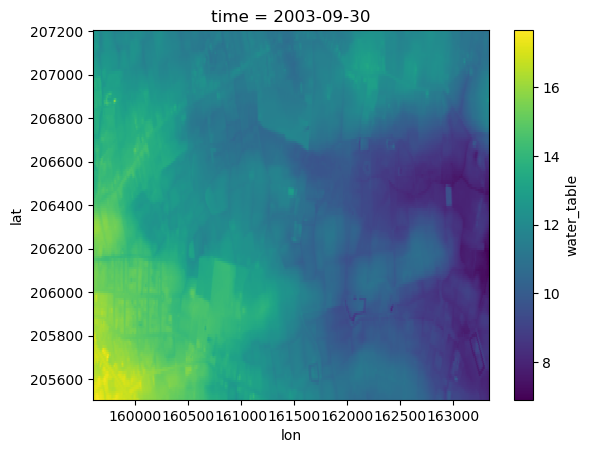

In [118]:
water_table_dataset.isel(time=0)["water_table"].plot()

In [14]:
#GitHub Copilot
# Convert the NetCDF file to an ASCII grid file using gdal_translate
# Construct the file paths
dest_folder=r'W:/VUB/main_research/data/molenbeek_bgk/gridded_gw_depth'
if not os.path.exists(os.path.join(os.getcwd(),dest_folder)):
    os.makedirs(dest_folder)

for i in range(len(gw_gridded_dataset['time'])):
    # Construct the file paths
    netcdf_file_path = os.path.join(dest_folder, f"gwdepth{i+1}.nc")
    ascii_file_path = os.path.join(dest_folder, f"gwdepth{i+1}.asc")

    gw_gridded_dataset.isel(time=i).to_netcdf(netcdf_file_path)
    # Convert the NetCDF file to an ASCII grid file using gdal_translate
    subprocess.run(['gdal_translate', '-of', 'AAIGrid', '-ot', 'Float32', '-co', 'DECIMAL_PRECISION=4','-a_nodata', '-9999', netcdf_file_path, ascii_file_path])

    # Remove the temporary NetCDF file
    os.remove(netcdf_file_path)

#### Interpolation accuracy check

Text(0, 0.5, 'groundwater depth (m)')

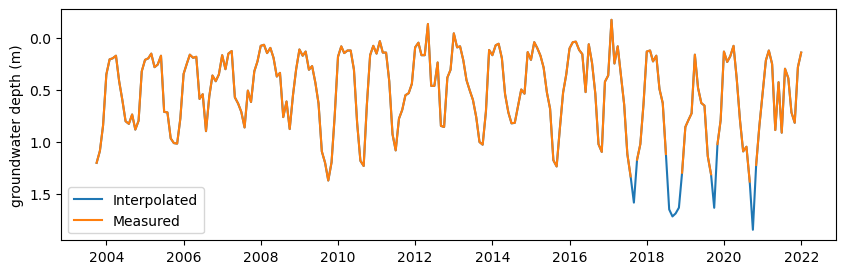

In [15]:
#chose one of the piezometers and plot the interpolated and measured groundwater depth
fig, ax = plt.subplots(figsize=(10, 3))
data=gw_gridded_dataset['groundwater_depth'].sel(lon=162003.87, lat=206395.85, method='nearest')
df=pd.DataFrame(data.values)
df['time']=gw_gridded_dataset['time']
df.set_index('time', inplace=True)
plt.plot(df.index, df.values)
plt.plot(gw_monthly_depth['C3']) #convert to meters and flip the sign
ax.invert_yaxis()
plt.legend(['Interpolated','Measured'])
plt.ylabel('groundwater depth (m)')

In [16]:
import numpy as np

# Specify the file path
ascii_file_path = "W:/VUB/main_research/data/molenbeek_bgk/gridded_gw_depth/gwdepth245.asc"

# Read the ASCII file
data = np.loadtxt(ascii_file_path, skiprows=6)


In [17]:
data

array([[0.2768, 0.2767, 0.2765, ..., 0.3514, 0.351 , 0.3506],
       [0.2764, 0.2762, 0.276 , ..., 0.3509, 0.3505, 0.3501],
       [0.2759, 0.2757, 0.2755, ..., 0.3504, 0.35  , 0.3496],
       ...,
       [0.2655, 0.2653, 0.2651, ..., 0.3072, 0.3073, 0.3074],
       [0.2659, 0.2656, 0.2654, ..., 0.3073, 0.3074, 0.3075],
       [0.2662, 0.266 , 0.2658, ..., 0.3075, 0.3076, 0.3076]])

In [19]:
gw_gridded_dataset['groundwater_depth'][25]

<xarray.DataArray 'groundwater_depth' (lat: 170, lon: 375)>
array([[1.8554, 1.8571, 1.8589, ..., 1.4385, 1.4396, 1.4407],
       [1.8548, 1.8566, 1.8583, ..., 1.4373, 1.4384, 1.4395],
       [1.8542, 1.856 , 1.8577, ..., 1.4361, 1.4373, 1.4384],
       ...,
       [1.7309, 1.7309, 1.7309, ..., 1.513 , 1.513 , 1.513 ],
       [1.7309, 1.7309, 1.7309, ..., 1.5142, 1.5142, 1.5142],
       [1.7309, 1.7309, 1.7309, ..., 1.5154, 1.5153, 1.5153]])
Coordinates:
  * lat      (lat) float64 2.072e+05 2.072e+05 2.072e+05 ... 2.055e+05 2.055e+05
  * lon      (lon) float64 1.596e+05 1.596e+05 1.596e+05 ... 1.633e+05 1.633e+05
    time     datetime64[ns] 2005-10-31
Attributes:
    units:    metres